In [15]:
import cv2

In [2]:
original_image = open("./data/weld1.jpeg")

In [14]:
print(type(original_image))

<class '_io.TextIOWrapper'>


In [4]:
import matplotlib.pyplot as plt

In [7]:
plt.show(original_image)

In [8]:
from PIL import Image

In [11]:
image = Image.open("./data/weld1.jpeg")

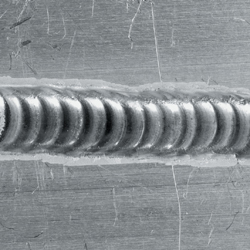

In [12]:
image

In [13]:
print(type(image))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [16]:
image2 = cv2.imread('./data/weld1.jpeg')
print(type(image2))

<class 'numpy.ndarray'>


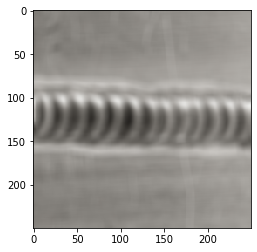

In [28]:
import numpy as np
from matplotlib import pyplot as plt
image = cv2.imread('./data/weld1.jpeg')

rows, cols = image.shape[:2]

def blur(image, filtersize):
    low_pass_filter = np.ones((filtersize, filtersize), np.float32) / filtersize**2
    dst = cv2.filter2D(image, -1, low_pass_filter)
    return dst

blur_image = blur(image, 10)
plt.imshow(blur_image)

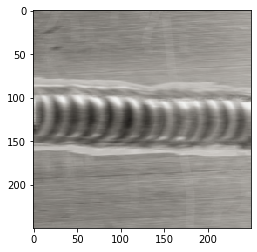

In [32]:
image = cv2.imread('./data/weld1.jpeg')
def motion_blur(image, size):
    motion_blur = np.zeros((size, size))
    motion_blur[int((size-1)/2), :] = np.ones(size)
    motion_blur = motion_blur / size
    dst = cv2.filter2D(image, -1, motion_blur)
    
    return dst

motion_image = motion_blur(image, 10)
plt.imshow(motion_image)

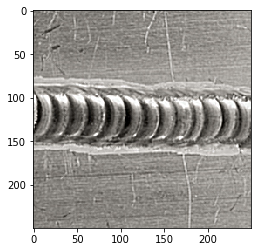

In [43]:
image = cv2.imread('./data/weld1.jpeg')
def sharpening(image):
    sharpening_1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpening_2 = np.array([[-1, -1, -1, -1, -1],
                             [-1, 2, 2, 2, -1],
                             [-1, 2, 9, 2, -1],
                             [-1, 2, 2, 2, -1],
                             [-1, -1, -1, -1, -1]]) / 9.0
    dst = cv2.filter2D(image, -1, sharpening_2)
    
    return dst

sharpening_image = sharpening(image)
plt.imshow(sharpening_image)

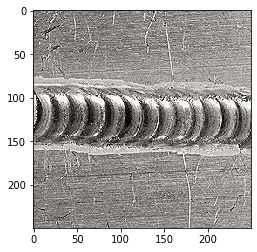

In [50]:
image = cv2.imread('./data/weld1.jpeg')
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

sharpening_out1 = cv2.filter2D(image, -1, sharpening_mask2)
plt.imshow(sharpening_out1)

### 랜덤 생성

In [ ]:
sharpening